Lab #1
Due No Due Date Points 100 Submitting a website url or a file upload
Dear all --

Answer the following questions:

1-- Choose one variable, look at its distribution, and plot a histogram of it.  Explain what you take away from looking at the variable.

2-- Choose some continuous-ish variable, and calculate its mean and standard deviation by some grouping variable.  Explain what conclusion you draw from this analysis.

3-- Choose two categorical-ish variables, and cross-tabulate them.  Explain what conclusion you draw from this analysis.


In [16]:
USE_GSS = False
from __future__ import division
import os, re
import urllib.request; exec(urllib.request.urlopen('https://raw.githubusercontent.com/srhoads/srhoads/master/python/functions.py').read())
pkg('pandas'); import pandas as pd
pkg('numpy'); import numpy as np
pkg('statsmodels'); import statsmodels.api as sm
import statsmodels.formula.api as smf
pkg('colour'); from colour import Color
import matplotlib.pyplot as plt

def printurn(x):
    print(x)
    return(x)

def recode_onehot_if(s='CHILDRENS COAT', pattern='CHILDREN'):
    result = '1' if pattern in str(s) else '0'
    return(result)

def check_color(color):
    try:
        Color(color)
        return True
    except ValueError:
        return False

def extract_color(pdcolumn):
    pdcolumn = pd.Series(pdcolumn.copy()) if type(pdcolumn)==str else pd.Series(pdcolumn) if type(pdcolumn)==list else pdcolumn
    newcolumn = pdcolumn.copy().apply(lambda s: ' '.join([i for i in str(s).split(' ') if check_color(i)]))
    return(newcolumn)

def compute_percentage(x, my_crosstab):
      pct = float(x/my_crosstab['count'].sum()) * 100
      return round(pct, 2)

# extract_color(d.head().Description)
    # _color = [i for i in s.split(' ') if check_color(i)]
# s = 'light green'
# _color = [i for i in s.split(' ') if check_color(i)]

### Reading data below! We're using our own custom dataset (not the GSS data!)

In [6]:
# # SAM CUSTOM (bc I personally hate downloading data files to my disk...):
if USE_GSS:
    # try:
    #     import gssapi
    # except:
    #     os.system('pip install gssapi'); import gssapi
    from io import BytesIO
    from zipfile import ZipFile
    from urllib.request import urlopen # or: requests.get(url).content

    resp = urlopen('http://gss.norc.org/documents/stata/2006_stata.zip')

    zipfile = ZipFile(BytesIO(resp.read()))
    dtafile = zipfile.namelist()[0]
    print(dtafile) # ['GSS2006.dta']
    d = pd.read_stata(zipfile.open(dtafile), convert_categoricals=False)
else:
    d = pd.read_csv('data.csv')
d

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


# I'm recoding some variables/creating new ones below! I'm also filtering the data so that it only has the observations we care about (valid UnitPrices and valid Quantity sold).

In [44]:
## df.loc[df.ID == 103, ['FirstName', 'LastName']] = 'Matt', 'Jones'
d_ = d.copy().apply(lambda y: y.str.lower() if str(y.dtype)=='object' else y).assign(
    children=lambda d: [recode_onehot_if(x, 'children') for x in d.Description],
    noun=lambda d: [str(x).split()[-1].strip() for x in d.Description],
    material=lambda d: d.Description.str.extract(r'(ceramic|metal|wood|plastic|cloth|felt|fabric|silk|polyester|linen|cotton|compostable|mahogany|canvas|cashmere|chiffon|denim|viscose|wool|fur|lace|leather|diamond|crystal|rhinestone|jewel|birch|rubber|wax|vintage|organic|pashmina|satin|spandex|suede)', expand=False, flags=re.IGNORECASE),
    # color=lambda d: d.Description.str.extract('\\b(pink|red|blue|white|green|yellow|purple|orange)\\b', expand=False, flags=re.IGNORECASE),
    color=lambda d: extract_color(d.Description),
    ).query('Quantity>=0 and UnitPrice>=0')
## d.assign(noun=lambda d: [str(x).split()[-1] for x in d.Description])
d_

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,children,noun,material,color
0,536365,85123a,white hanging heart t-light holder,6,12/1/2010 8:26,2.55,17850.0,united kingdom,0,holder,NaN,white
1,536365,71053,white metal lantern,6,12/1/2010 8:26,3.39,17850.0,united kingdom,0,lantern,metal,white
2,536365,84406b,cream cupid hearts coat hanger,8,12/1/2010 8:26,2.75,17850.0,united kingdom,0,hanger,NaN,
3,536365,84029g,knitted union flag hot water bottle,6,12/1/2010 8:26,3.39,17850.0,united kingdom,0,bottle,NaN,
4,536365,84029e,red woolly hottie white heart.,6,12/1/2010 8:26,3.39,17850.0,united kingdom,0,heart.,wool,red white
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,pack of 20 spaceboy napkins,12,12/9/2011 12:50,0.85,12680.0,france,0,napkins,NaN,
541905,581587,22899,children's apron dolly girl,6,12/9/2011 12:50,2.10,12680.0,france,1,girl,NaN,
541906,581587,23254,childrens cutlery dolly girl,4,12/9/2011 12:50,4.15,12680.0,france,1,girl,NaN,
541907,581587,23255,childrens cutlery circus parade,4,12/9/2011 12:50,4.15,12680.0,france,1,parade,NaN,


### Visualizing value counts & other descriptive statistics for the factors of our variable of interest (material)

In [26]:
# Checking value counts (frequencies) of words in the description field
pd.Series(' '.join(d_.Description.astype(str).unique().tolist()).split()).value_counts().head(20)

set          328
pink         301
of           241
heart        237
vintage      220
blue         215
red          198
bag          171
christmas    157
glass        156
box          138
white        132
design       129
holder       118
flower       115
small        115
metal        111
large        106
hanging      104
green        102
dtype: int64

In [27]:
# print(d_.noun.value_counts().head(20))
print(d_.value_counts().head(20))
# sorted(d_.noun.unique().tolist())

InvoiceNo  StockCode  Description                          Quantity  InvoiceDate       UnitPrice  CustomerID  Country         children  noun         material  color 
550331     85202      hanging wood and felt heart           1        4/17/2011 13:43   0.42       15555.0     united kingdom  0         heart        wood                5
538517     22749      feltcraft princess charlotte doll     1        12/12/2010 16:05  3.75       17618.0     united kingdom  0         doll         felt                5
580908     22139      retrospot tea set ceramic 11 pc       1        12/6/2011 13:20   4.95       16495.0     united kingdom  0         pc           ceramic             4
572861     21669      blue stripe ceramic drawer knob       6        10/26/2011 12:46  1.45       14102.0     united kingdom  0         knob         ceramic   blue      4
578041     22326      round snack boxes set of4 woodland    1        11/22/2011 14:23  2.95       17338.0     united kingdom  0         woodland     w

In [8]:
d_.material.value_counts()

vintage      33754
wood         25860
metal        21315
felt          9817
ceramic       9180
lace          3807
jewel         1932
crystal       1316
cloth          950
cotton         910
silk           783
fabric         685
wool           567
polyester      408
plastic        303
canvas         303
linen          126
rubber         126
denim           62
diamond         61
fur             50
suede           24
wax              2
Name: material, dtype: int64

In [10]:
summary = d_.material.describe()
summary.transpose()

count      112341
unique         23
top       vintage
freq        33754
Name: material, dtype: object

In [23]:
## Crosstabulation (like in Eirich's example!)
my_crosstab = pd.crosstab(index=d_["material"], columns="count")     
my_crosstab['percentage'] = my_crosstab.apply(lambda y: compute_percentage(y, my_crosstab), axis=1)
my_crosstab.sort_values('percentage', ascending=False)

col_0,count,percentage
material,,
vintage,33754,30.05
wood,25860,23.02
metal,21315,18.97
felt,9817,8.74
ceramic,9180,8.17
lace,3807,3.39
jewel,1932,1.72
crystal,1316,1.17
cloth,950,0.85


Below is a histogram of material! It's just demoing the value counts (which I explain below).

<AxesSubplot:>

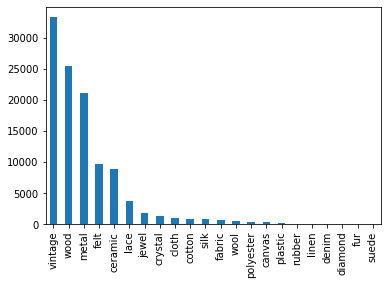

In [49]:
d_['material'].value_counts().plot(kind='bar')

# Answer to Q 1:
 
1-- The variable upon which I'm focusing is one that I custom-created from a text variable. Using the "Description" variable of the retail item in my sales dataset, I found that many of the described items include their materials (ie: metal, ceramic, wood, etc...). I thought this variable would be interesting because different materials of retail items might have different sales patterns (price, quantity, or even date/location purchased). 

I'm most interested in fashion-related retail items, so I defined a list of materials that I wanted to extract from the description column. I also included the code "vintage" even though it's not a specific material because it connotes a type of quality. This is a very rough first-go at defining a material list, but it's useful for now. The value counts are listed in the cell above. The most common codes are vintage, wood, metal, felt, and ceramic. Less common materials listed in item descriptions are diamond, fur, suede, wax.

As shown in the crosstabulation table above, 30.05% of the records have the "vintage" code. This isn't really a material, so I think I might recode it as a separate variable. Vintage must be a popular description in retail sales though!
The other factors with substantial percentages of the total are "wood" at 23.02%, "metal" at 18.97%, "felt" at 8.74%, "ceramic" at 8.17%, "lace" at 3.39%, "jewel" at 1.72%, and "crystal" at 1.17% of the observations. The other material factors make up under 1%. I could be more specific with some of these codes. For example, I could look for text including specific types of metal instead of "metal" at large.

# Answer to Q2:
*Question: 2-- Choose some continuous-ish variable, and calculate its mean and standard deviation by some grouping variable.  Explain what conclusion you draw from this analysis.*

For the histograms, I cropped the min and max X values to be more intuitive to the range of possibilities in the data itself. Quantity of item purchased can't ever be negative, so I restricted the X min to a quantity of 0.

count    531283.000000
mean         10.655299
std         156.830617
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64


array([[<AxesSubplot:title={'center':'Quantity'}>]], dtype=object)

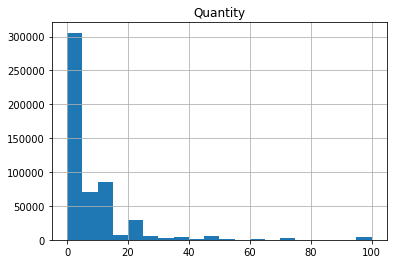

In [48]:
print(d_.Quantity.describe())
d_.hist(column='Quantity', range=(0, 100), bins=20)

count    531283.000000
mean          3.898954
std          35.876279
min           0.000000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64


array([[<AxesSubplot:title={'center':'UnitPrice'}>]], dtype=object)

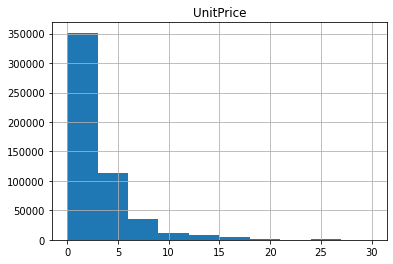

In [59]:
print(d_.UnitPrice.describe())
d_.hist(column='UnitPrice', range=(0, 30))

In [70]:
print('Mean of material x UnitPrice:\n\n', d_.groupby(['material'])['UnitPrice'].mean(), '\n\n')
print('Median of material x UnitPrice:\n\n', d_.groupby(['material'])['UnitPrice'].median(), '\n\n')
print('Standard Deviation of material x UnitPrice:\n\n', d_.groupby(['material'])['UnitPrice'].std(), '\n\n')
print('Count of material x UnitPrice (meaning unique unit prices per each material):\n\n', d_.groupby(['material'])['UnitPrice'].count(), '\n\n')

Mean of material x UnitPrice:

 material
canvas        1.891973
ceramic       2.417493
cloth         3.285293
cotton        3.741364
crystal       1.835095
denim         1.670328
diamond       8.883051
fabric        1.349868
felt          2.934777
fur          18.764600
jewel         4.927753
lace          3.500598
linen         3.593833
metal         2.811265
plastic       0.736140
polyester     1.479703
rubber        1.009920
silk          1.870425
suede         3.400000
vintage       3.659297
wood          3.749006
wool          4.312648
Name: UnitPrice, dtype: float64 


Median of material x UnitPrice:

 material
canvas        1.65
ceramic       1.45
cloth         1.65
cotton        2.95
crystal       1.63
denim         1.65
diamond       5.95
fabric        0.84
felt          2.95
fur          19.95
jewel         4.25
lace          2.95
linen         3.29
metal         2.10
plastic       0.83
polyester     1.45
rubber        0.42
silk          1.63
suede         2.95
vintage       

In [71]:
print('Mean of material x Quantity:\n\n', d_.groupby(['material'])['Quantity'].mean(), '\n\n')
print('Median of material x Quantity:\n\n', d_.groupby(['material'])['Quantity'].median(), '\n\n')
print('Standard Deviation of material x Quantity:\n\n', d_.groupby(['material'])['Quantity'].std(), '\n\n')
print('Count of material x Quantity (meaning unique quantity levels purchased per each material):\n\n', d_.groupby(['material'])['Quantity'].count(), '\n\n')

Mean of material x Quantity:

 material
canvas        9.056856
ceramic      18.659905
cloth         9.782748
cotton        3.330327
crystal       5.854087
denim         3.540984
diamond       3.355932
fabric        9.065982
felt          7.985098
fur           1.760000
jewel         8.716115
lace         10.346277
linen         4.675000
metal         8.592049
plastic       9.375439
polyester    11.279703
rubber       10.280000
silk         31.839125
suede         3.666667
vintage      10.419429
wood          9.155226
wool         10.787120
Name: Quantity, dtype: float64 


Median of material x Quantity:

 material
canvas       3
ceramic      6
cloth        3
cotton       2
crystal      2
denim        3
diamond      2
fabric       4
felt         4
fur          1
jewel        2
lace         3
linen        6
metal        3
plastic      4
polyester    4
rubber       2
silk         8
suede        3
vintage      4
wood         3
wool         4
Name: Quantity, dtype: int64 


Standard Deviati

Let's try grouping these variables by material! Material could be an interesting metric alongside price and quantity of items.

In [58]:
## Crosstabulation (like in Eirich's example!)
# pd.crosstab(d_.material, [d_.UnitPrice, d.Quantity], rownames=['material'], colnames=['UnitPrice', 'Quantity'])
pd.crosstab(d_.material, [d_.UnitPrice], rownames=['material'], colnames=['UnitPrice'])
# my_crosstab['percentage'] = my_crosstab.apply(lambda y: compute_percentage(y, my_crosstab), axis=1)
# my_crosstab.sort_values('percentage', ascending=False)

UnitPrice,0.00,0.04,0.12,0.19,0.20,0.21,0.22,0.25,0.29,0.32,...,58.29,59.53,78.29,79.95,85.00,110.00,125.00,175.00,195.00,295.00
material,,,,,,,,,,,,,,,,,,,,,
canvas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ceramic,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cloth,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cotton,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
crystal,0,0,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
denim,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
diamond,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fabric,0,0,0,11,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
felt,0,0,0,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
pd.crosstab(d_.material, [d_.Quantity], rownames=['material'], colnames=['Quantity'])

Quantity,1,2,3,4,5,6,7,8,9,10,...,1200,1296,1350,1394,1404,1500,1878,1944,2000,74215
material,,,,,,,,,,,,,,,,,,,,,
canvas,85,51,22,12,5,11,3,9,0,2,...,0,0,0,0,0,0,0,0,0,0
ceramic,1668,1129,685,804,93,828,51,177,46,57,...,0,0,1,0,0,0,0,0,0,1
cloth,233,190,60,52,19,24,3,8,1,6,...,0,0,0,0,0,0,0,0,0,0
cotton,403,171,49,34,14,174,1,10,0,0,...,0,0,0,0,0,0,0,0,0,0
crystal,584,188,91,58,31,97,11,10,5,12,...,0,0,0,0,0,0,0,0,0,0
denim,19,11,13,5,1,3,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
diamond,29,15,3,1,0,2,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
fabric,191,80,35,37,46,36,5,7,4,83,...,0,0,0,0,0,0,0,0,0,0
felt,2809,1216,616,1592,153,1027,30,312,16,40,...,0,3,0,0,0,0,0,0,0,0


In [51]:
my_crosstab

col_0,count
material,
canvas,299
ceramic,8874
cloth,939
cotton,887
crystal,1309
denim,61
diamond,59
fabric,682
felt,9730


# IGNORE THE FOLLOWING STUFF.....

In [20]:
try:
    from census import Census
    from us import states
except:
        os.system('pip install census, us, CensusData')
CENSUS_API_KEY = os.getenv('CENSUS_API_KEY')
c = Census(CENSUS_API_KEY)
# c.acs5.get(('NAME', 'B25034_010E'),{'for': 'state:{}'.format(states.MD.fips)})
# c.acs5.state(('NAME', 'B25034_010E'), states.MD.fips)
# import requests
# s = requests.session()
# s.headers.update({'User-Agent': 'census-demo/0.0'})

# c = Census(CENSUS_API_KEY, session=s)
# c.acs5.state('B01001_004E', Census.ALL)
os.environ
c.sf1.get('NAME', geo={'for': 'tract:*', 'in': 'state:{} county:170'.format(states.AK.fips)})

In [50]:
# print(d.columns.tolist())
os.system('pip install kaggle')
'kaggle datasets download -d PromptCloudHQ/innerwear-data-from-victorias-secret-and-others'

import requests
url="https://www.kaggle.com/carrie1/ecommerce-data/download"
r = requests.get(url)
r.headers


{'Date': 'Tue, 11 May 2021 15:41:10 GMT', 'Content-Type': 'text/html; charset=utf-8', 'Cache-Control': 'no-cache, no-store', 'Pragma': 'no-cache', 'Content-Encoding': 'gzip', 'Set-Cookie': 'CSRF-TOKEN=CfDJ8LdUzqlsSWBPr4Ce3rb9VL9lMxVZH7go3KhI5uRsDH7EhEyP6NS697CKxdPH2fGtgVmXj1wZBgVOaaWP0wIOnoYXKeApe1xIWJLYuM2vGG2olRIeiGJ32JircBagOHWfzrtRY5fTJ7yRq-RRxOtw02U; path=/; secure; samesite=lax; httponly, XSRF-TOKEN=CfDJ8LdUzqlsSWBPr4Ce3rb9VL9uVWGo7mPpEqCqhZTe-khEbedvBdyBrkGAmLE2GSfBU26Rc-O9saQAPbZNpQct-xUCy4XkL-mQPLcdP85eUHX_L7Mb0xBLTNKl1dChyXrWSlSAomLN38VKpUv2Ewv-AaU; path=/; secure; samesite=lax, CLIENT-TOKEN=eyJhbGciOiJub25lIiwidHlwIjoiSldUIn0.eyJpc3MiOiJrYWdnbGUiLCJhdWQiOiJjbGllbnQiLCJzdWIiOm51bGwsIm5idCI6IjIwMjEtMDUtMTFUMTU6NDE6MTAuNjUyMDQ2N1oiLCJpYXQiOiIyMDIxLTA1LTExVDE1OjQxOjEwLjY1MjA0NjdaIiwianRpIjoiMzkwYzRjMDItYzBmZS00MDhmLWE3YTMtYzhhMjljNWEyNGFiIiwiZXhwIjoiMjAyMS0wNi0xMVQxNTo0MToxMC42NTIwNDY3WiIsImFub24iOnRydWUsImZmIjpbIkp1cHl0ZXJMYWIiLCJEb2NrZXJNb2RhbFNlbGVjdG9yIiwiQWN0aXZlRXZlbnRzIiw

In [52]:
# import requests, csv
# from contextlib import closing
# url = 'https://www.kaggle.com/carrie1/ecommerce-data/download'
# with closing(requests.get(url, stream=True)) as r:
#     reader = csv.reader(r.iter_lines(), delimiter=',', quotechar='"')
# #     for row in reader:
# #         print(row)
#     [print(row) for row in reader]
import csv
import requests
CSV_URL = 'https://www.kaggle.com/carrie1/ecommerce-data/download'
with requests.Session() as s:
    download = s.get(CSV_URL)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)
    for row in my_list:
        print(row)

['<!DOCTYPE html>']
['<html lang="en">']
[]
['<head>']
['  <title>Kaggle: Your Home for Data Science</title>']
['  <meta charset="utf-8" />']
['  <meta name="robots" content="index', ' follow" />']
['  <meta name="description" content="Kaggle is the world&#x2019;s largest data science community with powerful tools and resources to help you achieve your data science goals." />']
['  <meta name="turbolinks-cache-control" content="no-cache" />']
['    <meta name="viewport" content="width=device-width', ' initial-scale=1.0', ' maximum-scale=5.0', ' minimum-scale=1.0">']
['  <meta name="theme-color" content="#008ABC" />']
['  <script nonce="3DB7gUmU3HMgAPHxPXpWng==" type="text/javascript">']
["    if ('serviceWorker' in navigator) {"]
['      navigator.serviceWorker.getRegistrations()']
['        .then(function (registrations) {']
['          for (let registration of registrations) {']
['            registration.unregister();']
['          }']
['        })']
['        .catch(function (err) 

## Sample answer to Q 1:
    
1-- I chose to look at a variable that investigates one of the Big Five dimensions of personality, as developed by psychologists. This variable, ​big5a1​, is the respondent's level of agreement to the following statement: I see myself as someone who is reserved; so it is basically a measure of introversion.

As Table 1 indicates, valid answers range from 1 to 5, where 1 represents strongagreement and 5 indicates strong disagreement (3=neither agreement or disagreement).

The below table, Table 2, shows that a large plurality of Americans (42%) agree that they are reserved, while only roughly a quarter of Americans assert they are not reserved (21% disagreeand only 7% strongly disagree). It is somewhat surprising how few Americans think of themselves as outgoing or bold, and yet few think of themselves as extremely shy (i.e., only 13% of people ​strongly​ agree they are reserved).

There is a histogram of this variable as well, which represents the same results of what I was talking about.

From the codebook, Table 1 is:

1019) I see myself as someone who is reserved. (BIG5A1) TOTAL % 1) Strongly agree 200 13.2 2) Agree 632 41.6 3) Neither agree nor disagree 253 16.7 4) Disagree 317 20.9 5) Strongly disagree 102 6.7 8) Can't choose 12 0.8 9) No answer 2 0.1 Missing 2992 TOTAL 1518 100

In [26]:
# os.chdir('C:/Users/gme2101/Desktop/Data Analysis Data') # change working directory

# ## I am using the codebook at http://www.thearda.com/Archive/Files/Codebooks/GSS2006_CB.asp ##

# d = pd.read_csv("GSS.2006.csv")
# d.head()